# Feature Importance Notebook for LightGBM Model

## Library Imports

In [20]:
## Import necessary libraries here
import os
import random
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import lightgbm as lgb

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from pathlib import Path
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.ticker import ScalarFormatter

warnings.filterwarnings("ignore")

In [21]:
# set the random seed for reproducibility
RANDOM_SEED = 2025

# Establish output directories for images and tables developed
IMAGE_DIR = Path("../Images/")
TABLE_DIR = Path("../Tables/")

In [22]:
# create helper functions to save images and tables to respective directories
def save_figure(fig, filename: str, dpi: int = 300) -> None:
    """
    Save a matplotlib/seaborn figure to the Images directory.
    """
    filepath = IMAGE_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure to {filepath}")

def save_table(df, filename: str, index: bool = False) -> None:
    """
    Save a pandas or polars DataFrame to the Tables directory as CSV.
    """
    filepath = TABLE_DIR / filename

    # Handle polars vs pandas
    if isinstance(df, pl.DataFrame):
        df.write_csv(str(filepath))
    else:
        # assume pandas-like
        df.to_csv(str(filepath), index=index)

    print(f"Saved table to {filepath}")


# create a list to hold results
results_rows = []  # will hold one row per model (on the test set)
# create funciton to record results
def record_results(results_dict, model_name: str) -> None:
    """
    Take the metrics dict returned by an evaluate_multiclass_model_* function
    and append a standardized row (TEST SET ONLY) to `results_rows`.
    """
    results_rows.append(
        {
            "model": model_name,
            "accuracy": results_dict["accuracy"],
            "precision_macro": results_dict["precision_macro"],
            "precision_weighted": results_dict["precision_weighted"],
            "recall_macro": results_dict["recall_macro"],
            "recall_weighted": results_dict["recall_weighted"],
            "f1_macro": results_dict["f1_macro"],
            "f1_weighted": results_dict["f1_weighted"],
        }
    )

## Data Importing and Loading

In [23]:
# set the filepath to the parquet cleaned dataset
PATH = "../Data/Cleaned/Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

df = scan.collect()
# drop the unneeded target columns for this 8-family analysis
df = df.drop(['Label', 'Label_Binary'])

# get schema
schema = df.schema

# cast Protocol_Type to categorical
df = df.with_columns(pl.col("Protocol_Type").cast(pl.Categorical))

In [24]:
# set feature and target variables
TARGET_FAMILY = 'Label_Family'

feature_columns = [col for col in df.columns if col != TARGET_FAMILY]

# categorical columns
CATEGORICAL_COLUMNS = ["Protocol_Type"]
# numerical columns
NUMERICAL_COLUMNS = [col for col, dtype in schema.items() if dtype in [pl.Int32, pl.Float32] and col != TARGET_FAMILY]

In [25]:
# convert to pandas for modeling
pdf = df.to_pandas()

X = pdf[feature_columns]
y = pdf[TARGET_FAMILY]

## Train / Test / Validation Split

In [26]:
# stratified split into train_full and temp (val+test)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,          # 70% train, 30% temp (val+test)
    stratify=y,
    random_state=RANDOM_SEED
)

# split temp into validation and test (both still imbalanced but representative)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,          # 15% val, 15% test overall
    stratify=y_temp,
    random_state=RANDOM_SEED
)

print("Class distribution (train_full):")
print(y_train_full.value_counts(normalize=True))

print("\nClass distribution (val):")
print(y_val.value_counts(normalize=True))

print("\nClass distribution (test):")
print(y_test.value_counts(normalize=True))

Class distribution (train_full):
Label_Family
DDOS           0.585191
DOS            0.198946
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64

Class distribution (val):
Label_Family
DDOS           0.585191
DOS            0.198947
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64

Class distribution (test):
Label_Family
DDOS           0.585191
DOS            0.198947
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64


In [27]:
# building the balanced training set via undersampling majority classes
# combine X_train_full and y_train_full for easier group-wise sampling
train_full_df = X_train_full.copy()
train_full_df[TARGET_FAMILY] = y_train_full.values

# Count examples per class
class_counts = train_full_df[TARGET_FAMILY].value_counts()
print("\nTraining class counts (before balancing):")
print(class_counts)

# Smallest class size (wundersample all classes down to this)
min_count = class_counts.min()
print(f"\nUsing min_count = {min_count} samples per class for balanced training.")

balanced_parts = []

for label, count in class_counts.items():
    class_subset = train_full_df[train_full_df[TARGET_FAMILY] == label]
    
    # Sample without replacement down to min_count for majority classes,
    # keep all samples for classes already at min_count
    if count > min_count:
        sampled = class_subset.sample(
            n=min_count,
            random_state=RANDOM_SEED
        )
    else:
        sampled = class_subset
    
    balanced_parts.append(sampled)

# Concatenate and shuffle to create the final balanced training set
train_balanced_df = (
    pd.concat(balanced_parts, axis=0)
      .sample(frac=1.0, random_state=RANDOM_SEED)  # shuffle
      .reset_index(drop=True)
)

# Separate features and target for the balanced training data
X_train_bal = train_balanced_df.drop(columns=[TARGET_FAMILY])
y_train_bal = train_balanced_df[TARGET_FAMILY]

print("\nTraining class counts (after balancing):")
print(y_train_bal.value_counts())


Training class counts (before balancing):
Label_Family
DDOS           8604454
DOS            2925243
MIRAI          1651428
BENIGN          733116
RECON           458825
SPOOFING        305243
WEB              16595
BRUTE_FORCE       8764
Name: count, dtype: int64

Using min_count = 8764 samples per class for balanced training.

Training class counts (after balancing):
Label_Family
DDOS           8764
MIRAI          8764
SPOOFING       8764
BRUTE_FORCE    8764
WEB            8764
DOS            8764
RECON          8764
BENIGN         8764
Name: count, dtype: int64


In [28]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_bal_enc = label_encoder.fit_transform(y_train_bal)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

class_names = label_encoder.classes_
n_classes = len(class_names)

## LightGBM Training of the Best Model

This section utilizes the best model found during the hyperparameter tuning phase in the modeling.ipynb notebook. The model is trained on the training dataset and evaluated on the test dataset to determine feature importance.

In [29]:
# Preprocessing: ColumnTransformer for numeric + categorical
# Numeric: passthrough (trees/boosting don't need scaling)
# Categorical: OneHotEncode Protocol_Type
numeric_features = NUMERICAL_COLUMNS
categorical_features = CATEGORICAL_COLUMNS

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# recreate the best LightGBM model from hyperparameter tuning
best_lgbm_model = LGBMClassifier(
    objective ='multiclass',
    random_state=RANDOM_SEED,
    n_estimators=250,
    num_leaves=63,
    max_depth=10,
    min_child_samples=40,
    subsample=0.8,
    colsample_bytree=0.7,
    learning_rate=0.05,
    n_jobs=-1
)

lgbm_best_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", best_lgbm_model)
    ]
)

In [30]:
# fit the tuned pipeline on the balanced training data
lgbm_best_pipeline.fit(X_train_bal, y_train_bal_enc)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3916
[LightGBM] [Info] Number of data points in the train set: 70112, number of used features: 38
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### SHAP Setup

In [31]:
# SHAP Setup: Background + Preprocessed Data
shap.initjs()

# get fitted steps
preprocessor_fitted = lgbm_best_pipeline.named_steps["preprocess"]
lgbm_model_fitted = lgbm_best_pipeline.named_steps["model"]

# background: sampled from balanced training (gives insight to what the model learned on)
background_size = min(5000, X_train_bal.shape[0])
X_background = X_train_bal.sample(
    n=background_size,
    random_state=RANDOM_SEED
)

X_background_trans = preprocessor_fitted.transform(X_background)
feature_names_transformed = preprocessor_fitted.get_feature_names_out()

X_background_trans_df = pd.DataFrame(
    X_background_trans,
    columns=feature_names_transformed
)

print(f"Using {background_size} balanced training samples as SHAP background.")

# Balanced training (for 'equal weight per family' perspective)
X_train_bal_trans = preprocessor_fitted.transform(X_train_bal)
X_train_bal_trans_df = pd.DataFrame(
    X_train_bal_trans,
    columns=feature_names_transformed
)

# Validation set (imbalanced, realistic)
X_val_trans = preprocessor_fitted.transform(X_val)
X_val_trans_df = pd.DataFrame(
    X_val_trans,
    columns=feature_names_transformed
)

# Test set (also imbalanced, held-out)
X_test_trans = preprocessor_fitted.transform(X_test)
X_test_trans_df = pd.DataFrame(
    X_test_trans,
    columns=feature_names_transformed
)

print("Preprocessed shapes:")
print(f"  Train (balanced): {X_train_bal_trans_df.shape}")
print(f"  Val (imbalanced): {X_val_trans_df.shape}")
print(f"  Test (imbalanced): {X_test_trans_df.shape}")

Using 5000 balanced training samples as SHAP background.
Preprocessed shapes:
  Train (balanced): (70112, 39)
  Val (imbalanced): (3150786, 39)
  Test (imbalanced): (3150786, 39)


### Global SHAP Feature Importance on Balanced Training Data

Treating each attack family equally, which features were the most important?

Using subsample of 2000 rows from balanced training set for SHAP (original size: 70112).
Computing SHAP values on balanced training subset...


100%|===================| 15993/16000 [90:39<00:02]        

Top 15 features by mean |SHAP| importance (Balanced Training Set, subsampled):


,feature,mean_abs_shap
0,num__fin_flag_number,0.177337
1,num__Rate,0.172831
2,num__psh_flag_number,0.169700
3,num__syn_flag_number,0.163879
4,num__Time_To_Live,0.133435
5,num__ack_flag_number,0.126897
6,num__rst_flag_number,0.126754
7,num__Header_Length,0.123071


Saved figure to ..\Images\LightGBM_SHAP_Feature_Importance_Bar_TrainBalanced.png


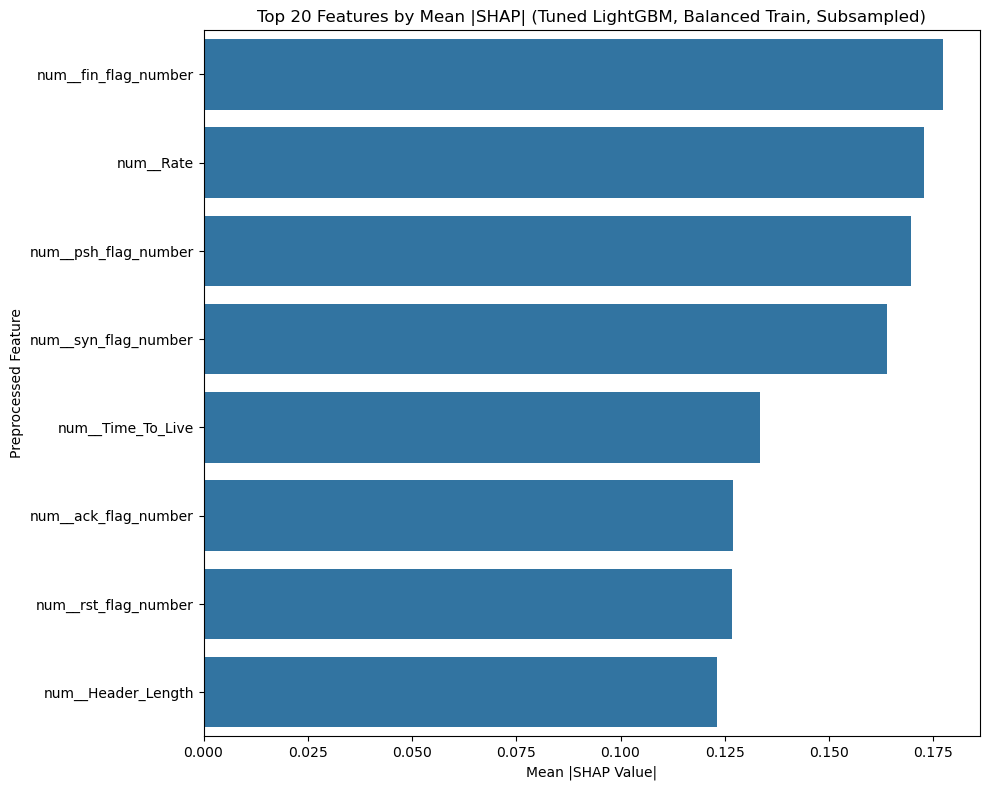

In [32]:
# SHAP Global Feature Importance - Balanced Training Set
# (subsampled, robust to SHAP output shape)
max_shap_samples_train = 2000  # cap for runtime

# treeExplainer with interventional perturbation and background
explainer_bal = shap.TreeExplainer(
    lgbm_model_fitted,
    data=X_background_trans_df,
    feature_perturbation="interventional"
)

# subsample balanced training data for SHAP
if X_train_bal_trans_df.shape[0] > max_shap_samples_train:
    X_train_bal_for_shap = X_train_bal_trans_df.sample(
        n=max_shap_samples_train,
        random_state=RANDOM_SEED
    )
    print(
        f"Using subsample of {max_shap_samples_train} rows from balanced training set for SHAP "
        f"(original size: {X_train_bal_trans_df.shape[0]})."
    )
else:
    X_train_bal_for_shap = X_train_bal_trans_df
    print(f"Using full balanced training set for SHAP (size: {X_train_bal_trans_df.shape[0]}).")

print("Computing SHAP values on balanced training subset...")
shap_values_train_bal = explainer_bal.shap_values(X_train_bal_for_shap)

# robust aggregation for mean |SHAP|
shap_arr_train = np.array(shap_values_train_bal)

if isinstance(shap_values_train_bal, list):
    # (n_classes, n_samples, n_features)
    shap_arr_train = np.stack(shap_values_train_bal, axis=0)
    mean_abs_shap_train = np.mean(np.abs(shap_arr_train), axis=(0, 1))  # -> (n_features,)
else:
    if shap_arr_train.ndim == 3:
        # (n_samples, n_classes, n_features)
        mean_abs_shap_train = np.mean(np.abs(shap_arr_train), axis=(0, 1))
    elif shap_arr_train.ndim == 2:
        # (n_samples, n_features) - binary-like
        mean_abs_shap_train = np.mean(np.abs(shap_arr_train), axis=0)
    else:
        raise ValueError(f"Unexpected SHAP array shape for train set: {shap_arr_train.shape}")

n_features_shap_train = shap_arr_train.shape[-1]

# align feature names and SHAP vector length
if len(feature_names_transformed) != n_features_shap_train:
    print(
        f"Warning: feature name length ({len(feature_names_transformed)}) "
        f"!= SHAP feature dimension ({n_features_shap_train}). Truncating to min length."
    )
    n_common = min(len(feature_names_transformed), n_features_shap_train)
    feature_names_used_train = feature_names_transformed[:n_common]
    mean_abs_shap_train = mean_abs_shap_train[:n_common]
else:
    feature_names_used_train = feature_names_transformed

shap_importance_train_df = (
    pd.DataFrame({
        "feature": feature_names_used_train,
        "mean_abs_shap": mean_abs_shap_train
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

print("Top 15 features by mean |SHAP| importance (Balanced Training Set, subsampled):")
display(shap_importance_train_df.head(15))

# Bar plot for balanced training
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20

sns.barplot(
    data=shap_importance_train_df.head(top_n),
    x="mean_abs_shap",
    y="feature",
    ax=ax
)
ax.set_title(
    f"Top {top_n} Features by Mean |SHAP| "
    f"(Tuned LightGBM, Balanced Train, Subsampled)"
)
ax.set_xlabel("Mean |SHAP Value|")
ax.set_ylabel("Preprocessed Feature")
plt.tight_layout()

save_figure(fig, "LightGBM_SHAP_Feature_Importance_Bar_TrainBalanced.png", dpi=300)
plt.show()
plt.close(fig)

### SHAP Feature Importance on Imbalanced Validation Data

Given an out-of-sample imbalanced dataset matching CICIoT2023 distributions, which features were the most influential in predictions?

Using subsample of 2000 rows from validation set for SHAP (original size: 3150786).
Computing SHAP values on validation subset (imbalanced)...


100%|===================| 15996/16000 [24:05<00:00]        

Top 15 features by mean |SHAP| importance (Validation Set, subsampled, imbalanced):


,feature,mean_abs_shap
0,num__Rate,0.255436
1,num__fin_flag_number,0.237070
2,num__syn_flag_number,0.187330
3,num__psh_flag_number,0.160297
4,num__Time_To_Live,0.145766
5,num__rst_flag_number,0.143176
6,num__ack_flag_number,0.140601
7,num__Header_Length,0.130208


Saved figure to ..\Images\LightGBM_SHAP_Feature_Importance_Bar_Val.png


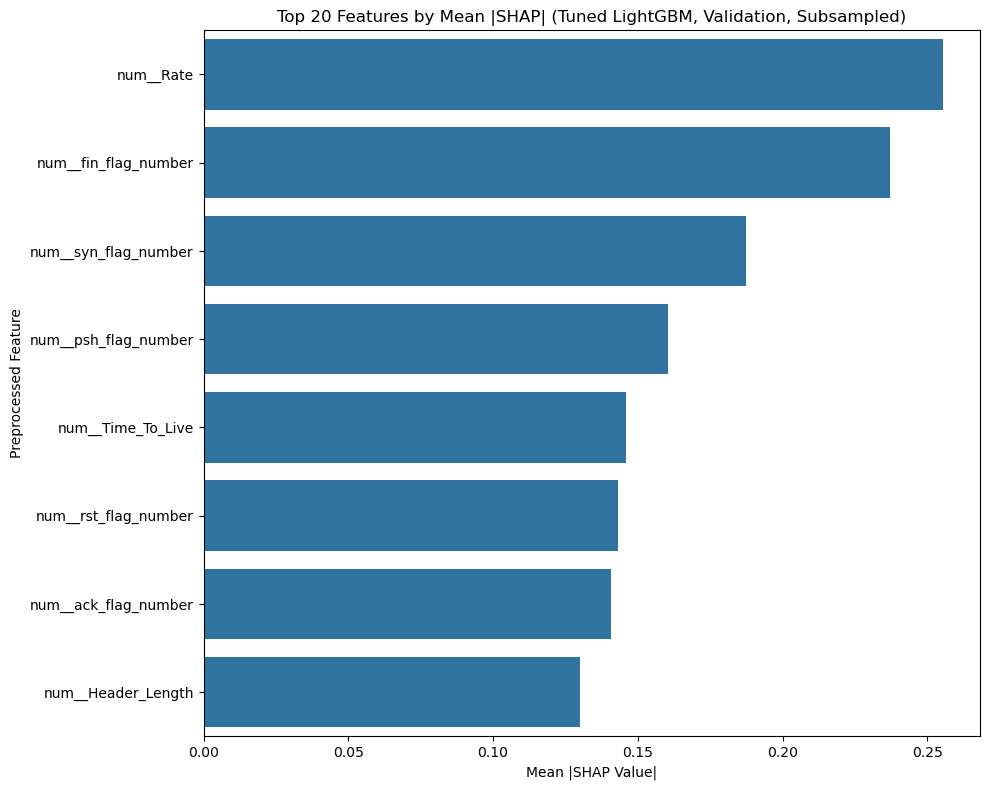

In [33]:

# SHAP Global Feature Importance - Validation Set
# (imbalanced, subsampled, robust)
max_shap_samples_val = 2000  # cap for runtime

# reuse the same explainer (same model + background)
explainer_val = explainer_bal

# subsample validation data for SHAP
if X_val_trans_df.shape[0] > max_shap_samples_val:
    X_val_for_shap = X_val_trans_df.sample(
        n=max_shap_samples_val,
        random_state=RANDOM_SEED
    )
    print(
        f"Using subsample of {max_shap_samples_val} rows from validation set for SHAP "
        f"(original size: {X_val_trans_df.shape[0]})."
    )
else:
    X_val_for_shap = X_val_trans_df
    print(f"Using full validation set for SHAP (size: {X_val_trans_df.shape[0]}).")

print("Computing SHAP values on validation subset (imbalanced)...")
shap_values_val = explainer_val.shap_values(X_val_for_shap,
                                            check_additivity=False)

# robust aggregation for mean |SHAP|
shap_arr_val = np.array(shap_values_val)

if isinstance(shap_values_val, list):
    # (n_classes, n_samples, n_features)
    shap_arr_val = np.stack(shap_values_val, axis=0)
    mean_abs_shap_val = np.mean(np.abs(shap_arr_val), axis=(0, 1))  # -> (n_features,)
else:
    if shap_arr_val.ndim == 3:
        # (n_samples, n_classes, n_features)
        mean_abs_shap_val = np.mean(np.abs(shap_arr_val), axis=(0, 1))
    elif shap_arr_val.ndim == 2:
        mean_abs_shap_val = np.mean(np.abs(shap_arr_val), axis=0)
    else:
        raise ValueError(f"Unexpected SHAP array shape for val set: {shap_arr_val.shape}")

n_features_shap_val = shap_arr_val.shape[-1]

# Align feature names and SHAP vector length
if len(feature_names_transformed) != n_features_shap_val:
    print(
        f"Warning: feature name length ({len(feature_names_transformed)}) "
        f"!= SHAP feature dimension ({n_features_shap_val}). Truncating to min length."
    )
    n_common_val = min(len(feature_names_transformed), n_features_shap_val)
    feature_names_used_val = feature_names_transformed[:n_common_val]
    mean_abs_shap_val = mean_abs_shap_val[:n_common_val]
else:
    feature_names_used_val = feature_names_transformed

shap_importance_val_df = (
    pd.DataFrame({
        "feature": feature_names_used_val,
        "mean_abs_shap": mean_abs_shap_val
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

print("Top 15 features by mean |SHAP| importance (Validation Set, subsampled, imbalanced):")
display(shap_importance_val_df.head(15))

# Bar plot for validation
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20

sns.barplot(
    data=shap_importance_val_df.head(top_n),
    x="mean_abs_shap",
    y="feature",
    ax=ax
)
ax.set_title(
    f"Top {top_n} Features by Mean |SHAP| "
    f"(Tuned LightGBM, Validation, Subsampled)"
)
ax.set_xlabel("Mean |SHAP Value|")
ax.set_ylabel("Preprocessed Feature")
plt.tight_layout()

save_figure(fig, "LightGBM_SHAP_Feature_Importance_Bar_Val.png", dpi=300)
plt.show()
plt.close(fig)


Generating SHAP beeswarm for class: BENIGN (index 0)
Saved figure to ..\Images\LightGBM_SHAP_Beeswarm_Val_Class_BENIGN.png


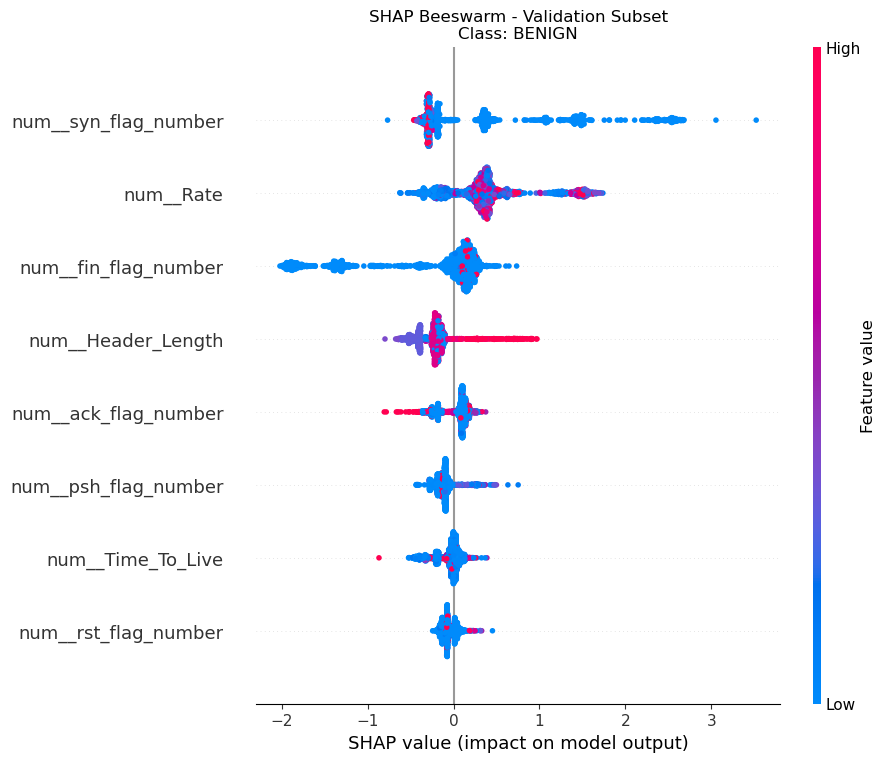


Generating SHAP beeswarm for class: BRUTE_FORCE (index 1)
Saved figure to ..\Images\LightGBM_SHAP_Beeswarm_Val_Class_BRUTE_FORCE.png


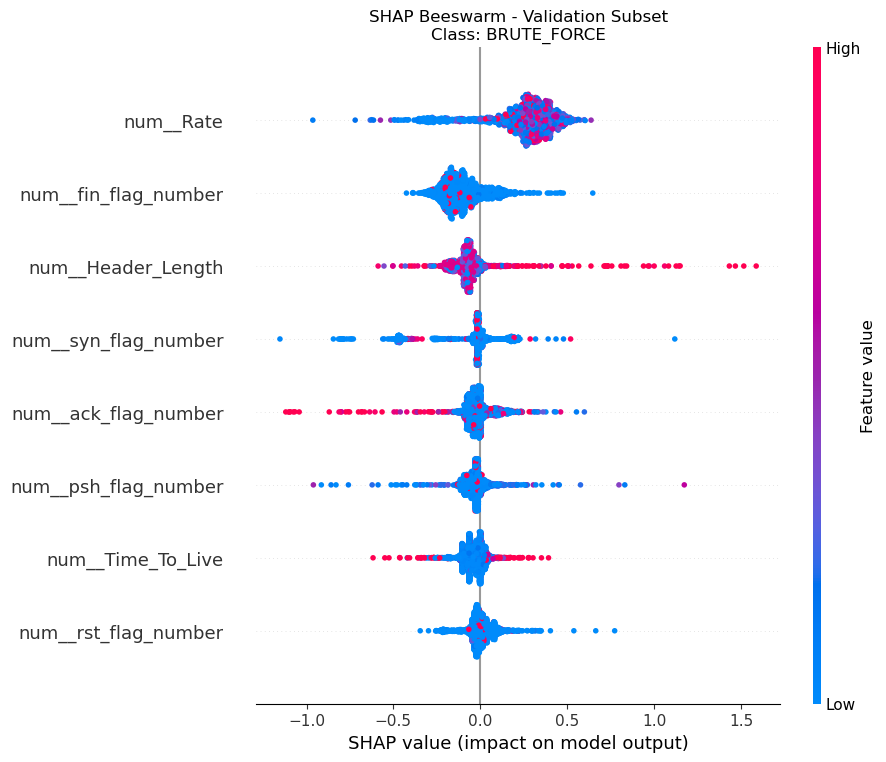


Generating SHAP beeswarm for class: DDOS (index 2)
Saved figure to ..\Images\LightGBM_SHAP_Beeswarm_Val_Class_DDOS.png


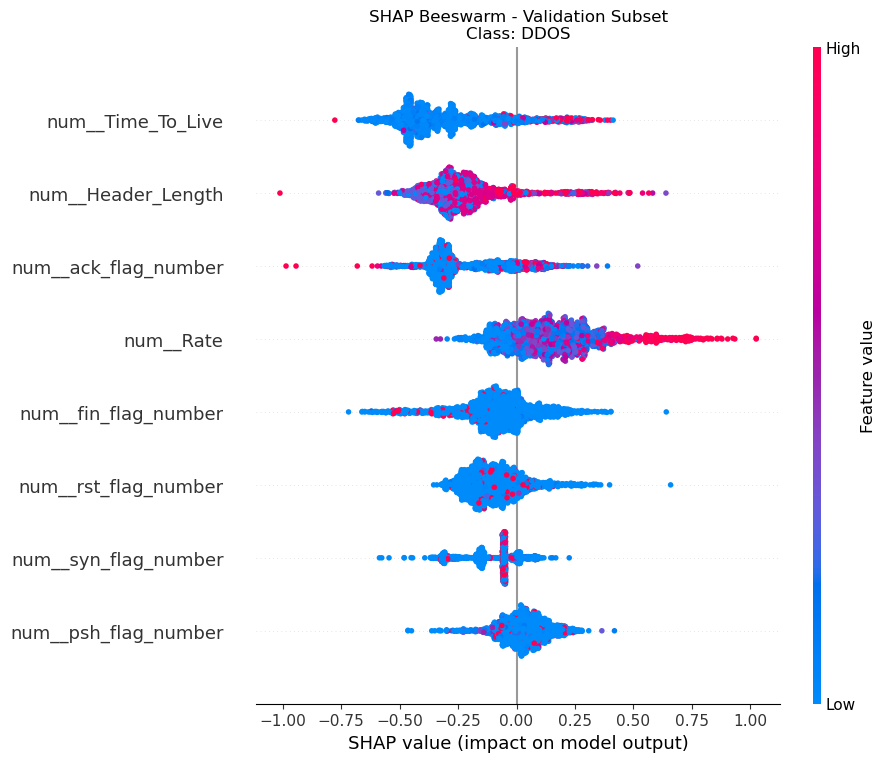


Generating SHAP beeswarm for class: DOS (index 3)
Saved figure to ..\Images\LightGBM_SHAP_Beeswarm_Val_Class_DOS.png


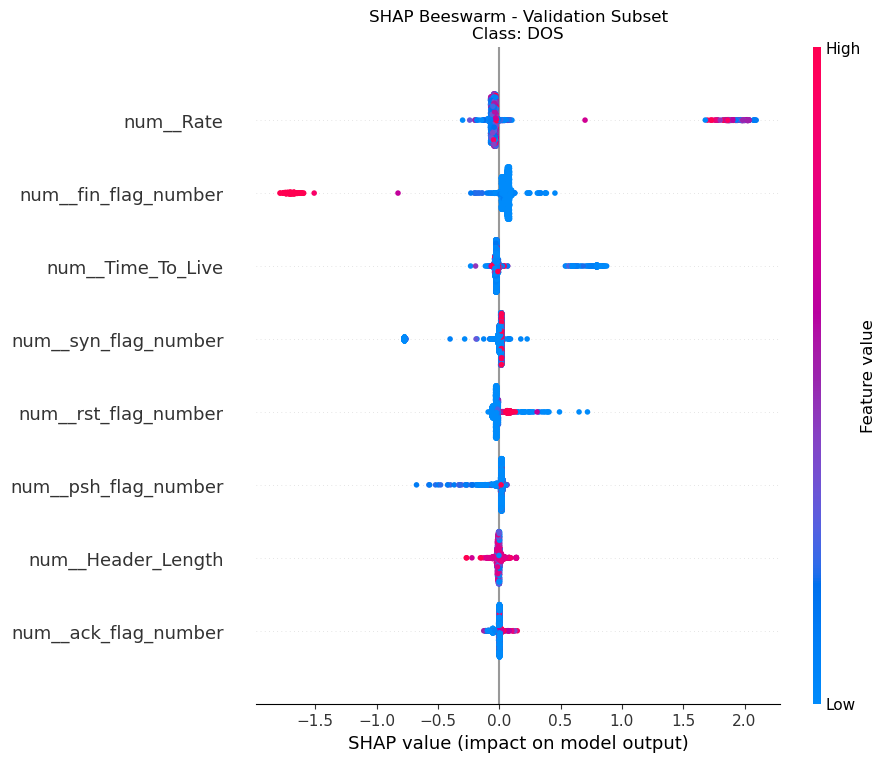


Generating SHAP beeswarm for class: MIRAI (index 4)
Saved figure to ..\Images\LightGBM_SHAP_Beeswarm_Val_Class_MIRAI.png


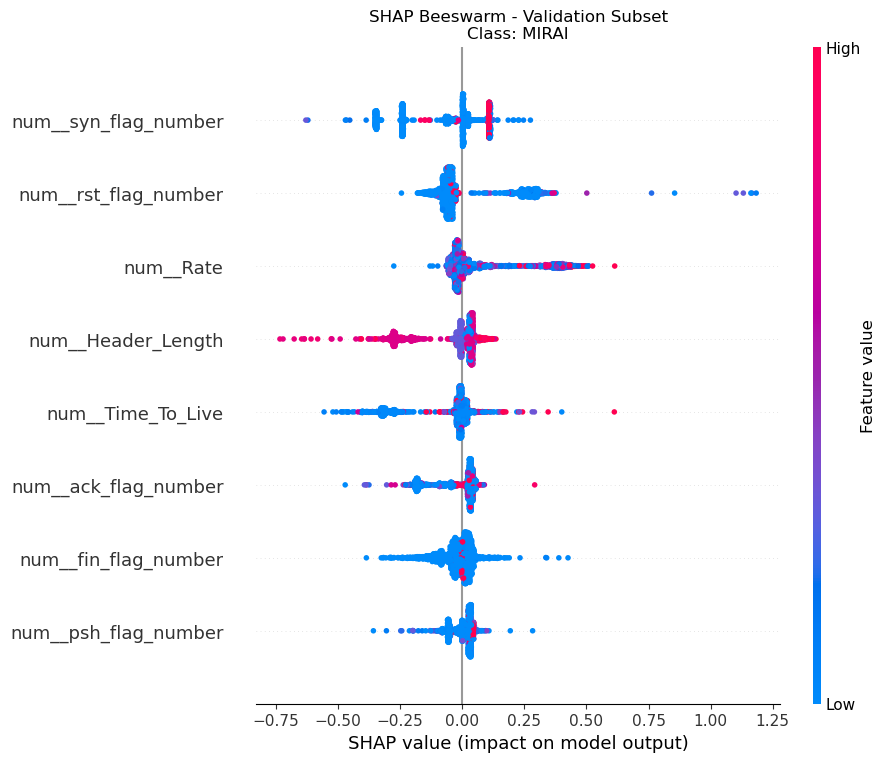


Generating SHAP beeswarm for class: RECON (index 5)
Saved figure to ..\Images\LightGBM_SHAP_Beeswarm_Val_Class_RECON.png


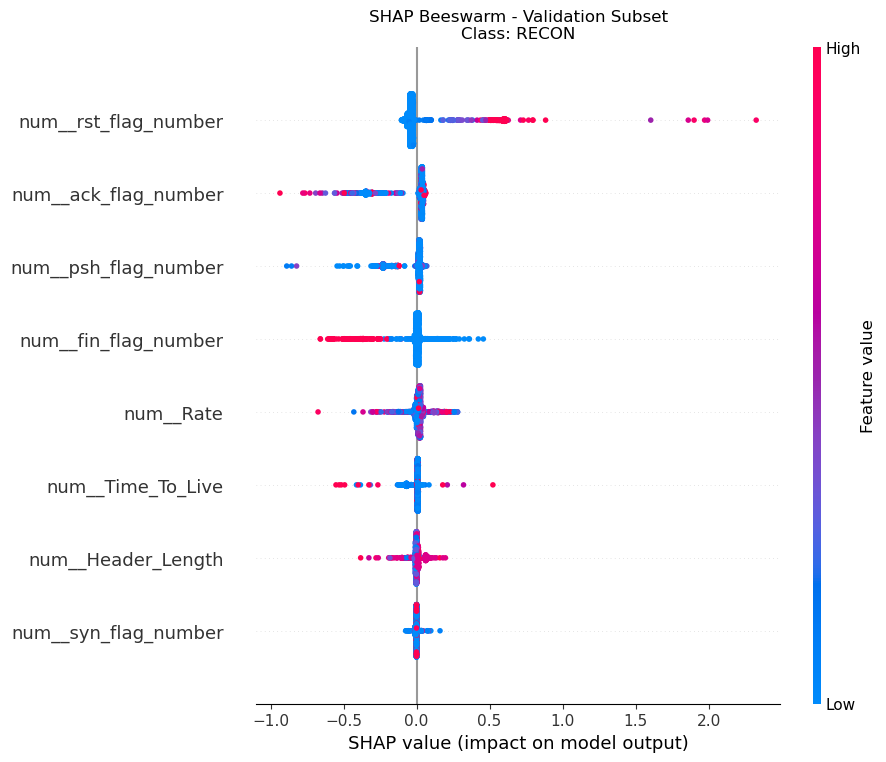


Generating SHAP beeswarm for class: SPOOFING (index 6)
Saved figure to ..\Images\LightGBM_SHAP_Beeswarm_Val_Class_SPOOFING.png


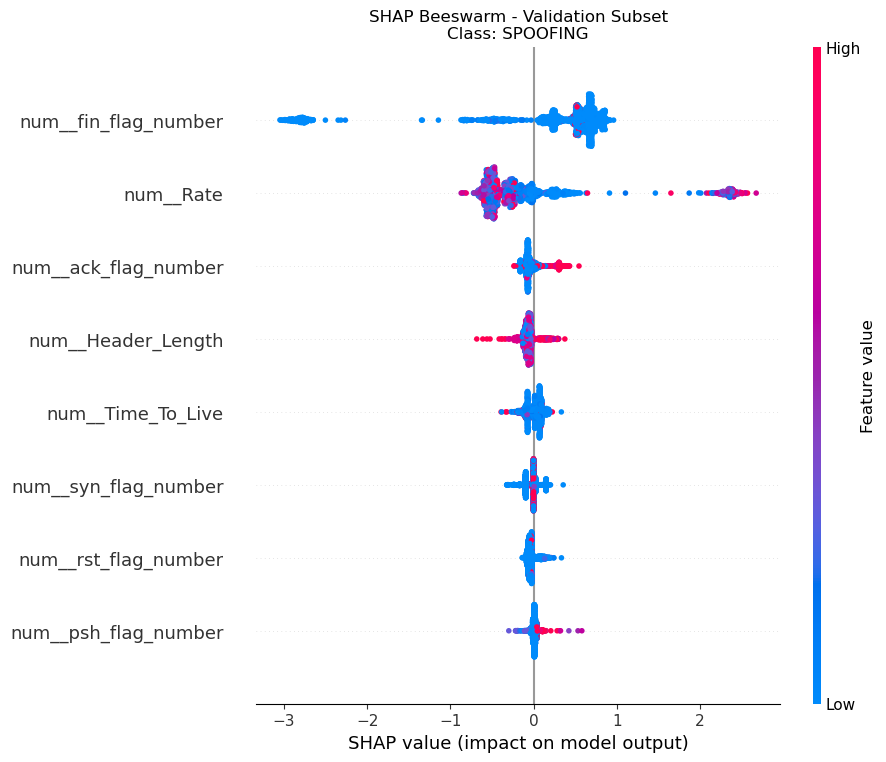


Generating SHAP beeswarm for class: WEB (index 7)
Saved figure to ..\Images\LightGBM_SHAP_Beeswarm_Val_Class_WEB.png


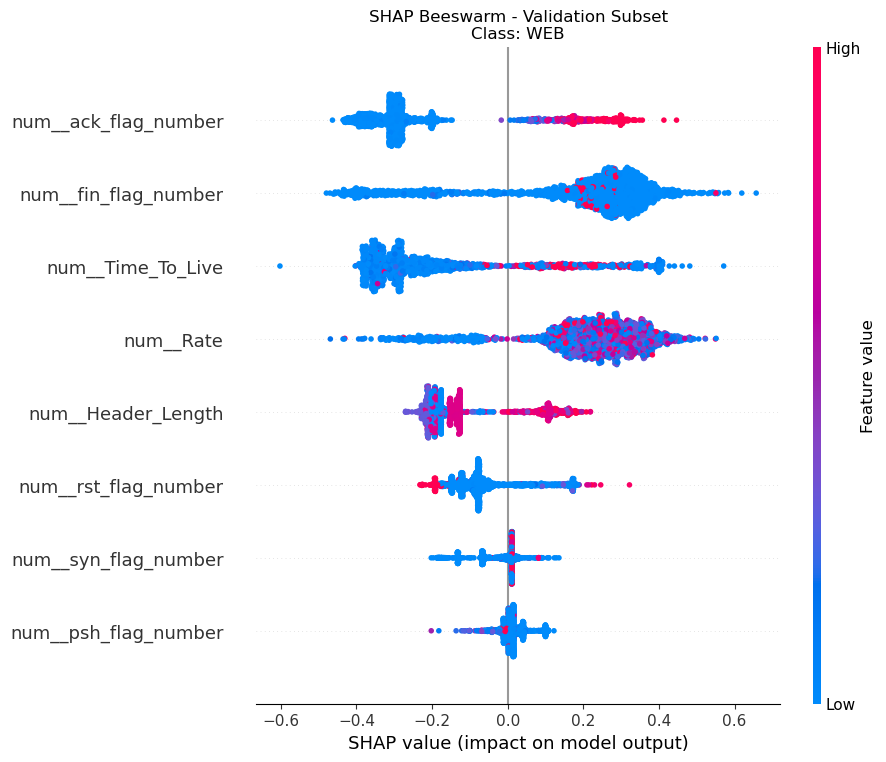


Generated one beeswarm plot per attack family (validation subset).


In [34]:
# Per-class SHAP Beeswarm - Validation Set
# one figure per attack family, version-safe + shape-safe
top_features_beeswarm = 15  # how many features to show per plot

# explainer_val.shap_values(X_val_for_shap, check_additivity=False)
for class_idx, class_name in enumerate(class_names):
    print(f"\nGenerating SHAP beeswarm for class: {class_name} (index {class_idx})")

    # pick SHAP values for this class
    if isinstance(shap_values_val, list):
        # standard multiclass: list of (n_samples, n_features [+ maybe 1])
        shap_values_for_beeswarm = np.array(shap_values_val[class_idx])
    else:
        shap_arr_val = np.array(shap_values_val)
        if shap_arr_val.ndim == 3:
            # could be (n_classes, n_samples, n_features) OR (n_samples, n_classes, n_features)
            if shap_arr_val.shape[0] == len(class_names):
                shap_values_for_beeswarm = shap_arr_val[class_idx, :, :]
            else:
                shap_values_for_beeswarm = shap_arr_val[:, class_idx, :]
        elif shap_arr_val.ndim == 2:
            # binary-like: (n_samples, n_features)
            shap_values_for_beeswarm = shap_arr_val
        else:
            raise ValueError(f"Unexpected SHAP array shape for beeswarm: {shap_arr_val.shape}")

    # ensure SHAP and X shapes are compatible
    sv = shap_values_for_beeswarm
    feat = X_val_for_shap

    # Row count must match
    if sv.shape[0] != feat.shape[0]:
        raise ValueError(
            f"Row mismatch for class {class_name}: "
            f"shap_values rows = {sv.shape[0]}, features rows = {feat.shape[0]}"
        )

    # if SHAP has one extra feature column (offset), drop the last one
    if sv.shape[1] == feat.shape[1] + 1:
        print(
            f"  Detected extra SHAP column for class {class_name} "
            f"(shap_features={sv.shape[1]}, X_features={feat.shape[1]}). "
            f"Dropping last SHAP column."
        )
        sv = sv[:, :feat.shape[1]]

    # if still mismatched, truncate both to common min dimension
    if sv.shape[1] != feat.shape[1]:
        min_dim = min(sv.shape[1], feat.shape[1])
        print(
            f"  Warning: feature dim mismatch for class {class_name} "
            f"(shap_features={sv.shape[1]}, X_features={feat.shape[1]}). "
            f"Truncating both to {min_dim}."
        )
        sv = sv[:, :min_dim]
        feat = feat.iloc[:, :min_dim]

    # make beeswarm plot for each class
    shap.summary_plot(
        sv,
        feat,
        plot_type="dot",
        max_display=top_features_beeswarm,
        show=False
    )

    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.title(f"SHAP Beeswarm - Validation Subset\nClass: {class_name}", fontsize=12)

    # save each figure
    filename = f"LightGBM_SHAP_Beeswarm_Val_Class_{class_name}.png"
    save_figure(fig, filename, dpi=300)

    plt.show()
    plt.close(fig)

print("\nGenerated one beeswarm plot per attack family (validation subset).")

## AUC-ROC Evaluation and FPR/TPR Tables

Shapes for ROC computation:
  y_test_enc:  (3150786,)
  y_test_bin:  (3150786, 8)
  y_test_proba:(3150786, 8)

Per-class AUCs (test set):
  BENIGN               : AUC = 0.9956
  BRUTE_FORCE          : AUC = 0.9920
  DDOS                 : AUC = 0.9401
  DOS                  : AUC = 0.9093
  MIRAI                : AUC = 1.0000
  RECON                : AUC = 0.9924
  SPOOFING             : AUC = 0.9975
  WEB                  : AUC = 0.9900

Micro-average AUC: 0.9839
Macro-average AUC: 0.9771
Saved figure to ..\Images\LightGBM_ROC_Multiclass_Test.png


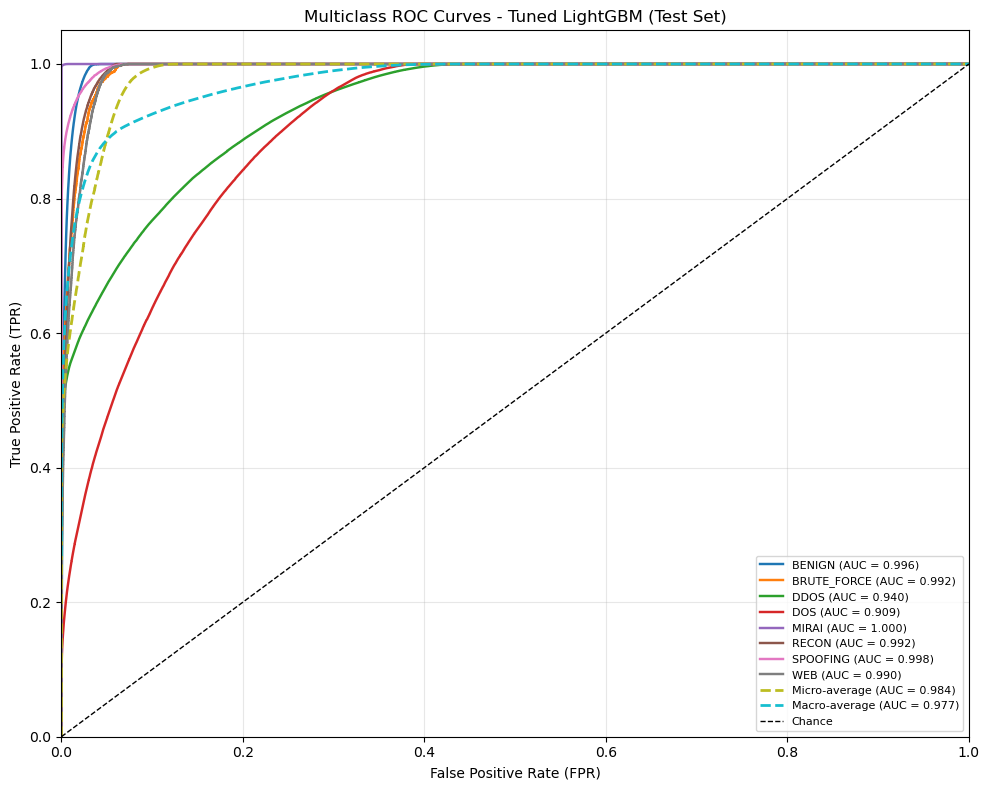


Sample of ROC points (per-class FPR/TPR/threshold):


,class_index,class_name,threshold,false_positive_rate,true_positive_rate
0,0,BENIGN,inf,0.000000e+00,0.000000
1,0,BENIGN,0.975670,3.340359e-07,0.000000
2,0,BENIGN,0.972650,3.340359e-07,0.000006
3,0,BENIGN,0.971847,3.340359e-07,0.000019
4,0,BENIGN,0.964446,3.340359e-07,0.000248



ROC–AUC summary (per-class + micro/macro):


,type,class_index,class_name,roc_auc
0,per_class,0.0,BENIGN,0.995624
1,per_class,1.0,BRUTE_FORCE,0.992045
2,per_class,2.0,DDOS,0.940099
3,per_class,3.0,DOS,0.909319
4,per_class,4.0,MIRAI,0.999990
5,per_class,5.0,RECON,0.992397
6,per_class,6.0,SPOOFING,0.997548
7,per_class,7.0,WEB,0.990049
8,aggregate,NaN,micro_average,0.983930
9,aggregate,NaN,macro_average,0.977134


Saved table to ..\Tables\LightGBM_ROC_AUC_Summary_Test.csv


In [35]:
# Multiclass ROC–AUC on Test Set
# One-vs-rest ROC curves for each family
# Micro and macro averages
# FPR / TPR / threshold tables

# predict probabilities on the held-out test set
y_test_proba = lgbm_best_pipeline.predict_proba(X_test)  # shape: (n_samples, n_classes)

# binarize the encoded test labels for one-vs-rest ROC
y_test_bin = label_binarize(y_test_enc, classes=np.arange(n_classes))

print("Shapes for ROC computation:")
print(f"  y_test_enc:  {y_test_enc.shape}")
print(f"  y_test_bin:  {y_test_bin.shape}")
print(f"  y_test_proba:{y_test_proba.shape}")

# compute ROC curves and AUC for each class
fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}
roc_auc_dict = {}

for i in range(n_classes):
    fpr_i, tpr_i, thresholds_i = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    auc_i = auc(fpr_i, tpr_i)

    fpr_dict[i] = fpr_i
    tpr_dict[i] = tpr_i
    thresholds_dict[i] = thresholds_i
    roc_auc_dict[i] = auc_i

# micro-average ROC (flatten all classes)
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# macro-average ROC (average TPR at each FPR)
all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])

mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

print("\nPer-class AUCs (test set):")
for i, cname in enumerate(class_names):
    print(f"  {cname:20s} : AUC = {roc_auc_dict[i]:.4f}")
print(f"\nMicro-average AUC: {roc_auc_micro:.4f}")
print(f"Macro-average AUC: {roc_auc_macro:.4f}")

# plot ROC curves for each class + micro + macro
fig, ax = plt.subplots(figsize=(10, 8))

# per-class curves
for i, cname in enumerate(class_names):
    ax.plot(
        fpr_dict[i],
        tpr_dict[i],
        lw=1.75,
        label=f"{cname} (AUC = {roc_auc_dict[i]:.3f})"
    )

# micro and macro curves
ax.plot(
    fpr_micro,
    tpr_micro,
    linestyle="--",
    linewidth=2,
    label=f"Micro-average (AUC = {roc_auc_micro:.3f})"
)

ax.plot(
    all_fpr,
    mean_tpr,
    linestyle="--",
    linewidth=2,
    label=f"Macro-average (AUC = {roc_auc_macro:.3f})"
)

# chance line
ax.plot([0, 1], [0, 1], "k--", lw=1, label="Chance")

ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_title("Multiclass ROC Curves - Tuned LightGBM (Test Set)")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(loc="lower right", fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
save_figure(fig, "LightGBM_ROC_Multiclass_Test.png", dpi=300)
plt.show()
plt.close(fig)

# FPR / TPR / Threshold Tables per class
# Long-format table: one row per threshold per class
roc_points_rows = []

for i in range(n_classes):
    cname = class_names[i]
    fpr_i = fpr_dict[i]
    tpr_i = tpr_dict[i]
    thr_i = thresholds_dict[i]

    # roc_curve returns len(thresholds) == len(tpr) == len(fpr)
    for fpr_val, tpr_val, thr_val in zip(fpr_i, tpr_i, thr_i):
        roc_points_rows.append(
            {
                "class_index": i,
                "class_name": cname,
                "threshold": thr_val,
                "false_positive_rate": fpr_val,
                "true_positive_rate": tpr_val,
            }
        )

roc_points_df = pd.DataFrame(roc_points_rows)

print("\nSample of ROC points (per-class FPR/TPR/threshold):")
display(roc_points_df.head())

# save full ROC points table
# save_table(roc_points_df, "LightGBM_ROC_FPR_TPR_Thresholds_Test.csv", index=False)

# Summary Table: ROC–AUC per Class + Micro/Macro
auc_rows = []

for i in range(n_classes):
    auc_rows.append(
        {
            "type": "per_class",
            "class_index": i,
            "class_name": class_names[i],
            "roc_auc": roc_auc_dict[i],
        }
    )

# add micro and macro rows
auc_rows.append(
    {
        "type": "aggregate",
        "class_index": None,
        "class_name": "micro_average",
        "roc_auc": roc_auc_micro,
    }
)

auc_rows.append(
    {
        "type": "aggregate",
        "class_index": None,
        "class_name": "macro_average",
        "roc_auc": roc_auc_macro,
    }
)

roc_auc_summary_df = pd.DataFrame(auc_rows)

print("\nROC–AUC summary (per-class + micro/macro):")
display(roc_auc_summary_df)

# save summary table
save_table(roc_auc_summary_df, "LightGBM_ROC_AUC_Summary_Test.csv", index=False)
